## Chapter 2: Loading a Quantized Model

### Spoilers

In this chapter, we’ll:

- Understand how quantization works
- Explore the pros and cons of using different data types (FP16, BF16, FP32)
- Introduce the concept of mixed-precision computing
- Use BitsAndBytes to quantize a pretrained model while loading it

### Setup

In [ ]:
# If you're running on Colab
!pip install datasets bitsandbytes trl

In [ ]:
# If you're running on runpod.io's Jupyter Template
#!pip install transformers peft huggingface-hub accelerate safetensors pandas matplotlib

### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from accelerate import init_empty_weights
from accelerate.utils.modeling import find_tied_parameters, get_mixed_precision_context_manager
from accelerate.utils.operations import convert_outputs_to_fp32
from bitsandbytes.nn import Linear8bitLt, Linear4bit, LinearFP4, LinearNF4
from collections import Counter
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, AutoConfig
from transformers.integrations.bitsandbytes import get_keys_to_not_convert
from types import MethodType
from matplotlib import pyplot as plt

### The Goal

We quantize models to reduce their memory footprint. We can easily shrink the model’s size to a quarter or an eighth of its original size. Keep in mind, however, that the more a model is quantized (i.e., the fewer bit used
to represent its weights), the more likely its performance will be negatively affected.

### Pre-Reqs

| Type | Name | # bits | Nickname |
|---|---|---|---|
| FP32 | Floating Point | 32 | Full Precision |
| BF16 | Brain Float | 16 | Half-Precision |
| FP16 | Floating Point | 16 | Half-Precision |
| INT8 | Integer | 8 | 8-bit Quantized |
| FP4 | Floating Point | 4 | 4-bit Quantized |
| NF4 | Normal Float | 4 | 4-bit Quantized |

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_sizes.png?raw=True)
<center>Figure 2.1 - Data type’s size comparison</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/model_sizes.png?raw=True)
<center>Figure 2.2 - Representing the same model using different data types</center>

### Quantization in a Nutshell

In [2]:
torch.manual_seed(11)
weights = torch.randn(1000) * .07
weights.min(), weights.max()

(tensor(-0.2066), tensor(0.2097))

In [3]:
n_bins = 4
bins = torch.linspace(weights.min(), weights.max(), n_bins+1)
bin_width = bins[1]-bins[0]
bins, bin_width

(tensor([-0.2066, -0.1026,  0.0015,  0.1056,  0.2097]), tensor(0.1041))

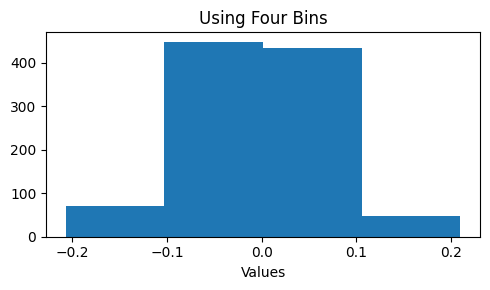

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
counts, _, _ = ax.hist(weights, bins=bins)
ax.set_xlabel('Values')
ax.set_title('Using Four Bins')
fig.tight_layout()

In [6]:
bin_indexes = (weights.view(-1, 1) > bins).to(torch.int).argmin(dim=1) - 1
print(weights[:20])
print(bin_indexes[:20])

tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048,  0.0099, -0.0367,
        -0.0174, -0.0368,  0.2025, -0.0416,  0.0918,  0.0247, -0.0921, -0.0006,
         0.0174,  0.1101, -0.1148, -0.1115])
tensor([1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 0, 0])


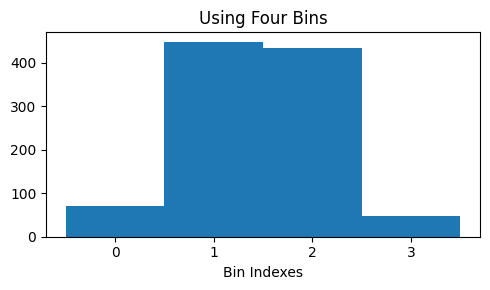

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
counts, _, _ = ax.hist(bin_indexes, bins=np.arange(n_bins+1)-.5)
ax.set_xticks([0, 1, 2, 3])
ax.set_xlabel('Bin Indexes')
ax.set_title('Using Four Bins')
fig.tight_layout()


$$
\Large
\text{n_bins}=2^{\text{n_bits}} \implies \text{n_bits} = \log_2({\text{n_bins}})
$$

<center>Equation 2.1 - Number of bits vs number of bins</center>

In [9]:
bin_values = bins[:-1]
first_bin = bin_values[0]
bin_values

tensor([-0.2066, -0.1026,  0.0015,  0.1056])


$$
\Large
\text{approx_value} = \text{bin_index} * \text{bin_width} + \text{first_bin}
$$

<center>Equation 2.2 - Retrieving the (approximate) original value</center>

In [10]:
torch.arange(0, n_bins) * bin_width + first_bin

tensor([-0.2066, -0.1026,  0.0015,  0.1056])

In [11]:
approx_values = bin_indexes * bin_width + first_bin
print(approx_values[:20])

tensor([-0.1026,  0.0015, -0.1026,  0.0015, -0.1026, -0.2066,  0.0015, -0.1026,
        -0.1026, -0.1026,  0.1056, -0.1026,  0.0015,  0.0015, -0.1026, -0.1026,
         0.0015,  0.1056, -0.2066, -0.2066])


In [12]:
print(weights[:20])

tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048,  0.0099, -0.0367,
        -0.0174, -0.0368,  0.2025, -0.0416,  0.0918,  0.0247, -0.0921, -0.0006,
         0.0174,  0.1101, -0.1148, -0.1115])


In [13]:
import torch.nn as nn
mse_fn = nn.MSELoss()
mse_fn(approx_values, weights).sqrt()

tensor(0.0615)

In [14]:
def quantize(weights, n_bits=8):
    assert n_bits <= 16, "Using more bits may very slow execution and/or crashing."
    n_bins = 2**n_bits
    bins = torch.linspace(weights.min(), weights.max(), n_bins+1)
    first_bin = bins[0]
    bin_width = bins[1]-bins[0]
    bin_indexes = (weights.view(-1, 1) > bins).to(torch.int).argmin(dim=1) - 1
    return bin_indexes, bin_width, first_bin

def dequantize(bin_indexes, bin_width, first_bin):
    approx_values = bin_indexes * bin_width + first_bin
    return approx_values

In [15]:
for n_bits in [2, 4, 8, 16]:
    res = quantize(weights, n_bits=n_bits)
    approx_values = dequantize(*res)
    print(f'{n_bits}-bit Quantization:')
    print(approx_values[:6])
    print(weights[:6])
    print(mse_fn(approx_values, weights).sqrt())
    print('\n')

2-bit Quantization:
tensor([-0.1026,  0.0015, -0.1026,  0.0015, -0.1026, -0.2066])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0615)


4-bit Quantization:
tensor([-0.0505,  0.0535, -0.0505,  0.0015, -0.0245, -0.1286])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0152)


8-bit Quantization:
tensor([-0.0359,  0.0714, -0.0261,  0.0080, -0.0131, -0.1058])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0010)


16-bit Quantization:
tensor([-0.0359,  0.0718, -0.0248,  0.0085, -0.0128, -0.1049])
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])
tensor(0.0001)




****
**ASIDE: Weight Distribution of Phi-3's Linear Layers**

The following plots show the weight distribution of a large linear layer, `qkv_proj`, within the self-
attention block in Phi-3. Other layers, such as `o_proj`, also located within the self-attention block, and
`gate_up_proj` and `down_proj`, in the MLP block, have very similar weight distributions. This layer is
present in every one of the 32 decoder blocks (indicated by the number in square brackets). You’ll notice
that these millions of weights are concentrated within a very narrow range. But there are a few outliers as
well, so each subplot also contains the actual range of observed weights in the corresponding layer.

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/self_attn.qkv_proj.png?raw=True)
<center>Figure 2.5 - Weight distribution of Phi-3 layers</center>

****

### Half-Precision Weights

In [16]:
fp16_weights = weights.to(torch.float16)
print(fp16_weights[:6])
print(weights[:6])

tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048],
       dtype=torch.float16)
tensor([-0.0358,  0.0720, -0.0247,  0.0086, -0.0127, -0.1048])


In [17]:
print(mse_fn(fp16_weights, weights).sqrt())

tensor(1.4244e-05)


#### Living on the Edge

In [18]:
torch.manual_seed(14)
tiny_values = torch.randn(1000)*1e-5
fp16_tiny_values = tiny_values.to(torch.float16)
mse_fn(fp16_tiny_values, tiny_values)

tensor(2.8526e-16)

In [19]:
print(tiny_values[155:160])
print(fp16_tiny_values[155:160])

tensor([-2.7241e-06,  1.1441e-05,  3.7199e-06, -1.1252e-06, -2.4735e-08])
tensor([-2.7418e-06,  1.1444e-05,  3.6955e-06, -1.1325e-06, -0.0000e+00],
       dtype=torch.float16)


In [20]:
torch.manual_seed(19)
large_values = torch.randn(1000)*1e5
fp16_large_values = large_values.to(torch.float16)
print(large_values[:5])
print(fp16_large_values[:5])

tensor([155074.0938,  64881.6602,   2729.5815, -40790.6562,  68846.7188])
tensor([    inf,  64896.,   2730., -40800.,     inf], dtype=torch.float16)


In [21]:
fp16_info = torch.finfo(torch.float16)
fp16_info

finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

In [22]:
smallest_subnormal = fp16_info.smallest_normal * 2**-10
smallest_subnormal

5.960464477539063e-08

### The Brain Float

In [23]:
bf16_info = torch.finfo(torch.bfloat16)
print(bf16_info)
print(fp16_info)

finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)
finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)


In [24]:
fp32_info = torch.finfo(torch.float32)
fp32_info

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

In [25]:
x = torch.tensor([0.555555555])
torch.set_printoptions(precision=9)
print(x)
print(x.to(torch.float16))
print(x.to(torch.bfloat16))
torch.set_printoptions(precision=4)

tensor([0.555555582])
tensor([0.555664062], dtype=torch.float16)
tensor([0.554687500], dtype=torch.bfloat16)


|Type | Precision | Sub-normal | Min. | Max. |
|---|---|---|---|---|
|FP32 | e-08 | e-45 | e-38 | e+38 |
|BF16 | e-03  | NA | e-38 | e+38 |
|FP16 | e-04  | e-08  | e-05 | e+04 |

### Loading Models

****
**Summary of "Loading Models"**
- if supported by your GPU, use `torch.bfloat16` instead of `torch.float16` for all things 16-bit
 ```python
 supported = torch.cuda.is_bf16_supported(including_emulation=False)
 dtypes16 = (torch.bfloat16 if supported else torch.float16)
 ```
- when loading a pretrained model, always specify its `torch_dype` upfront
 ```python
 model = AutoModelForCausalLM.from_pretrained(repo_id, device_map='auto', torch_dtype=torch.float32)
 ```
****

In [26]:
def get_parm_dtypes(iterable, top_k=3):
    return Counter([p.dtype for p in iterable]).most_common(top_k)

In [28]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", device_map='auto')
print(model.get_memory_footprint()/1e6)   
print(get_parm_dtypes(model.parameters()))

1324.785664
[(torch.float32, 388)]


In [45]:
!wget https://huggingface.co/facebook/opt-350m/resolve/main/pytorch_model.bin
!ls -la pytorch_model.bin

-rw-rw-r-- 1 dvgodoy dvgodoy 662513657 May 11  2022 pytorch_model.bin


In [46]:
state_dict = torch.load('pytorch_model.bin')
get_parm_dtypes(iter(state_dict.values()))

[(torch.float16, 388)]

In [29]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto',
                                             torch_dtype=torch.float32)

In [30]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
batch = tokenizer(['This is a simple test'], return_tensors='pt')
batch['labels'] = batch['input_ids']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = {k: v.to(device) for k, v in batch.items()}

In [31]:
out = model(**batch)
out.loss

tensor(3.8001, device='cuda:0', grad_fn=<NllLossBackward0>)

#### Half-Precision Models (16-bit)

In [33]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
dtype16 = (torch.bfloat16 if supported else torch.float16)
dtype16

torch.float16

In [34]:
model.to(dtype16)
print(model.get_memory_footprint()/1e6)
get_parm_dtypes(model.parameters())

662.392832


[(torch.float16, 388)]

In [35]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                             device_map='auto',
                                             torch_dtype=dtype16)
print(model.get_memory_footprint()/1e6)
print(get_parm_dtypes(model.parameters()))

662.392832
[(torch.float16, 388)]


In [36]:
out = model(**batch)
out.loss

tensor(3.8008, device='cuda:0', dtype=torch.float16,
       grad_fn=<NllLossBackward0>)

### Mixed Precision

In [142]:
class MixedModel(nn.Module):
    def __init__(self, dtype):
        super().__init__()
        self.a = nn.Linear(1000, 1000, dtype=dtype)
        self.b = nn.Linear(1000, 1000, dtype=dtype)
        
    def forward(self, x):
        return self.b(self.a(x))

In [143]:
mixed32 = MixedModel(torch.float32)
mixed32.to('cuda')

MixedModel(
  (a): Linear(in_features=1000, out_features=1000, bias=True)
  (b): Linear(in_features=1000, out_features=1000, bias=True)
)

In [122]:
%timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))

1.41 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [120]:
mixed16 = MixedModel(torch.float16)
mixed16.to('cuda')

MixedModel(
  (a): Linear(in_features=1000, out_features=1000, bias=True)
  (b): Linear(in_features=1000, out_features=1000, bias=True)
)

In [123]:
%timeit mixed16(torch.randn(1000, 1000, dtype=torch.float16, device='cuda'))

248 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [125]:
with torch.autocast(device_type="cuda", dtype=torch.float16):
    %timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))

277 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [149]:
with torch.autocast(device_type="cuda", dtype=torch.float16):
    res16 = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
    
res32 = res16.float()

torch.float32

In [144]:
autocast_context = torch.autocast(device_type="cuda", dtype=torch.float16)
# original forward method
model_forward_func = mixed32.forward.__func__
# wrapping the method with the context manager
new_forward = autocast_context(model_forward_func)
# assigning the wrapped method back to the model
mixed32.forward = MethodType(new_forward, mixed32)

In [145]:
res = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
res.dtype

torch.float16

In [146]:
mixed32.forward = MethodType(convert_outputs_to_fp32(mixed32.forward.__func__), mixed32)

In [147]:
res = mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))
res.dtype

torch.float32

In [134]:
%timeit mixed32(torch.randn(1000, 1000, dtype=torch.float32, device='cuda'))

371 µs ± 1.27 µs per loop  (mean ± std. dev. of 7 runs, 1000 loops each)


### BitsAndBytes

[BitsAndBytes](https://huggingface.co/docs/bitsandbytes/main/en/index) is your go-to package for quantization. From its documentation:

"_bitsandbytes enables accessible large language models via k-bit quantization for PyTorch. bitsandbytes provides three main features for dramatically reducing memory consumption for inference and training:_

- _8-bit optimizers uses block-wise quantization to maintain 32-bit performance at a small fraction of the memory cost._
- _LLM.Int() or 8-bit quantization enables large language model inference with only half the required memory and without any performance degradation. This method is based on vector-wise quantization to quantize most features to 8-bits and separately treating outliers with 16-bit matrix multiplication._
- _QLoRA or 4-bit quantization enables large language model training with several memory-saving techniques that don’t compromise performance. This method quantizes a model to 4-bits and inserts a small set of trainable low-rank adaptation (LoRA) weights to allow training._"

In [37]:
bnb_config = BitsAndBytesConfig()
bnb_config

BitsAndBytesConfig {
  "_load_in_4bit": false,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": false,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

#### 8-Bit Quantization

"_LLM.int8() is a quantization method that doesn’t degrade performance which makes large model inference more accessible. The key is to extract the outliers from the inputs and weights and multiply them in 16-bit. All other values are multiplied in 8-bit and quantized to Int8 before being dequantized back to 16-bits. The outputs from the 16-bit and 8-bit multiplication are combined to produce the final output._"

Source: [8-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear8bit)

****
**Summary of "8-Bit Quantization"**
- load an 8-bit quantized model in a few lines of code:
  ```python
    bnb_config = BitsAndBytesConfig(load_in_8bit=True)
    model = AutoModelForCausalLM.from_pretrained(repo_id, 
                                                 device_map='auto',
                                                 torch_dtype=torch.float32,
                                                 quantization_config=bnb_config)
  ```
  - quantization modifies the default type of non-quantized layers to `torch.float16` unless we actively provide the `torch_dtype` argument when calling the `from_pretrained()` method
- 8-bit quantization replaces all linear layers except for:
  - layers with tied (shared) weights
  - the last layer in the model
  - any layer named `lm_head`
- if you want to skip additional modules, use the `llm_int8_skip_modules` configuration argument and make sure to manually include the layers with tied (shared) weights to avoid errors
- computation (inside the quantized layers) happens in `torch.float16`
****

In [76]:
bnb_config_q8 = BitsAndBytesConfig(load_in_8bit=True)
model_q8 = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                                device_map='auto',
                                                quantization_config=bnb_config_q8)
print(model_q8.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q8.parameters()))

359.354368
[(torch.float16, 242), (torch.int8, 146)]


In [77]:
# you may not get a NaN back, as it depends on the environment
out = model_q8(**batch)
out.loss

tensor(nan, device='cuda:0', dtype=torch.float16, grad_fn=<NllLossBackward0>)

In [41]:
model_q8_32 = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                                device_map='auto',
                                                quantization_config=bnb_config_q8,
                                                torch_dtype=torch.float32)
print(model_q8_32.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q8_32.parameters()))

415.670272
[(torch.float32, 242), (torch.int8, 146)]


In [42]:
out = model_q8_32(**batch)
out.loss

  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


tensor(3.8024, device='cuda:0', grad_fn=<NllLossBackward0>)

##### Quantized Linear Layers

In [51]:
dec_layer = model_q8_32.model.decoder.layers[0]
dec_layer

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (v_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
    (out_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear8bitLt(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear8bitLt(in_features=4096, out_features=1024, bias=True)
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [52]:
q8_layer = dec_layer.self_attn.k_proj
q8_layer

Linear8bitLt(in_features=1024, out_features=1024, bias=True)

In [53]:
q8_state = q8_layer.state_dict()
q8_state

OrderedDict([('weight',
              tensor([[ -67, -113,  -89,  ...,   65,  -16,  -87],
                      [  60,  120,   90,  ...,  -50,   32,   80],
                      [  47,  127,   86,  ...,  -34,    8,   90],
                      ...,
                      [ -65,   65,   34,  ...,  -64,   35,   64],
                      [  57,   67,   21,  ...,   63,  -64,  -64],
                      [ -64,   63,  -11,  ...,  -64,   34,   63]], device='cuda:0',
                     dtype=torch.int8)),
             ('bias',
              tensor([-0.0134,  0.0082,  0.0161,  ..., -0.0242, -0.0150,  0.0203],
                     device='cuda:0')),
             ('SCB',
              tensor([0.1250, 0.1252, 0.1250,  ..., 0.1252, 0.1250, 0.1254], device='cuda:0')),
             ('weight_format', tensor(0, dtype=torch.uint8))])

In [60]:
print(model.model.decoder.embed_tokens)
print(model.lm_head)

Embedding(50272, 512, padding_idx=1)
Linear(in_features=512, out_features=50272, bias=False)


In [61]:
torch.allclose(model.model.decoder.embed_tokens.weight, 
               model.lm_head.weight)

True

In [57]:
config = AutoConfig.from_pretrained('facebook/opt-350m')

config.tie_word_embeddings, find_tied_parameters(model)

(True, [['lm_head.weight', 'model.decoder.embed_tokens.weight']])

In [58]:
with init_empty_weights(): # loads meta tensors only
    empty_model = AutoModelForCausalLM.from_config(config)

empty_model.lm_head.weight

Parameter containing:
tensor(..., device='meta', size=(50272, 512), requires_grad=True)

In [59]:
skip_modules = get_keys_to_not_convert(empty_model)
skip_modules

['lm_head', 'model.decoder.embed_tokens']

In [62]:
for module in skip_modules:
    print(f'{module}: {next(model_q8_32.get_submodule(module).parameters()).dtype}')

lm_head: torch.float32
model.decoder.embed_tokens: torch.float32


#### `llm_int8_skip_modules`

If your model has tied weights, and you choose to use your own list of modules to skip, you
must add one of the tied layers to your list. If you don’t, you may get the following
exception:

***
`AttributeError: 'Parameter' object has no attribute 'SCB'`
***

```python
# This configuration WILL raise an exception 
# while trying to load weights for the tied layer
# bnb_config_skip = BitsAndBytesConfig(load_in_8bit=True, 
#                                      llm_int8_skip_modules=['o_proj'])

# This configuration works fine because 
# the tied layer, lm_head, is in the list
bnb_config_skip = BitsAndBytesConfig(
        load_in_8bit=True, 
        llm_int8_skip_modules=['o_proj', 'lm_head'])

model_skip = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                                  device_map='auto',
                                                  torch_dtype=torch.float32,
                                                  quantization_config=bnb_config_skip)
```

##### 8-bit Layers

"*In order to quantize a linear layer one should first load the original fp16 / bf16 weights into the Linear8bitLt module, then call int8_module.to("cuda") to quantize the fp16 weights.*"

Source: [8-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear8bit)

In [63]:
n_in = 10
n_out = 10

torch.manual_seed(11)
fp_layer = nn.Linear(n_in, n_out)

int8_layer = Linear8bitLt(n_in, n_out, has_fp16_weights=False)

int8_layer.load_state_dict(fp_layer.state_dict())
int8_layer.state_dict()

OrderedDict([('weight',
              tensor([[-0.2220, -0.0085,  0.3072, -0.2097,  0.0531,  0.1224,  0.0525, -0.2350,
                        0.0456,  0.2687],
                      [-0.1459,  0.1786, -0.1443, -0.0233,  0.1689,  0.0015, -0.2514,  0.1644,
                        0.1920,  0.1678],
                      [ 0.2346,  0.1411,  0.2128,  0.0519,  0.2147, -0.2786, -0.0433, -0.0364,
                       -0.1504,  0.0823],
                      [ 0.2388, -0.2134, -0.1620, -0.1023,  0.2433, -0.2680,  0.3099, -0.1933,
                       -0.0471, -0.0391],
                      [-0.1273,  0.2197, -0.0136, -0.1938, -0.1746,  0.0404,  0.0711, -0.1730,
                        0.0539, -0.1992],
                      [-0.0051,  0.1373, -0.0267, -0.0907, -0.0107,  0.1108, -0.1566,  0.0172,
                        0.2075, -0.0028],
                      [ 0.2082, -0.2857, -0.2640, -0.1436,  0.1704,  0.1908, -0.2350,  0.1187,
                       -0.0568,  0.0916],
                 

In [64]:
int8_layer = int8_layer.to(0) # Quantization happens here
int8_state = int8_layer.state_dict()
int8_state

OrderedDict([('weight',
              tensor([[ -92,   -4,  127,  -87,   22,   51,   22,  -97,   19,  111],
                      [ -74,   90,  -73,  -12,   85,    1, -127,   83,   97,   85],
                      [ 107,   64,   97,   24,   98, -127,  -20,  -17,  -69,   38],
                      [  98,  -87,  -66,  -42,  100, -110,  127,  -79,  -19,  -16],
                      [ -74,  127,   -8, -112, -101,   23,   41, -100,   31, -115],
                      [  -3,   84,  -16,  -56,   -7,   68,  -96,   11,  127,   -2],
                      [  93, -127, -117,  -64,   76,   85, -104,   53,  -25,   41],
                      [ 123, -127,   23,   79,   11,  -79,  -24,  -39,  102,  117],
                      [ -51, -127,  -41,  -71,  110,  122,   67,  -11, -125,    9],
                      [ -50,    1,  -60,  -13,   73,  127,  106,  -70,   84,   84]],
                     device='cuda:0', dtype=torch.int8)),
             ('bias',
              tensor([ 0.1269,  0.2999,  0.0252, -0.038

#### 4-bit Quantization

"*QLoRA is a finetuning method that quantizes a model to 4-bits and adds a set of low-rank adaptation (LoRA) weights to the model and tuning them through the quantized weights. This method also introduces a new data type, 4-bit NormalFloat (LinearNF4) in addition to the standard Float4 data type (LinearFP4). LinearNF4 is a quantization data type for normally distributed data and can improve performance.*"

Source: [4-bit quantization](https://huggingface.co/docs/bitsandbytes/en/reference/nn/linear4bit)

****
**Summary of "4-Bit Quantization"**
- squeeze the most of a 4-bit quantized model by using the normal float (NF4) type and double quantization
  ```python
  supported = torch.cuda.is_bf16_supported(including_emulation=False)
  compute_dtype = (torch.bfloat16 if supported else torch.float32)
  nf4_config = BitsAndBytesConfig(
     load_in_4bit=True,
     bnb_4bit_quant_type="nf4",
     bnb_4bit_use_double_quant=True,
     bnb_4bit_compute_dtype=compute_dtype
  )
  model = AutoModelForCausalLM.from_pretrained(repo_id, 
                                               device_map='auto',
                                               torch_dtype=torch.float32,
                                               quantization_config=nf4_config)
  ```
- computation happens (inside the quantized layers) in the specified type (`bnb_4bit_compute_dtype`):
FP32 is better than BF16, which is better than FP16.
****

In [67]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
compute_dtype = (torch.bfloat16 if supported else torch.float32)

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=compute_dtype
)

**The Secret Lives of `Dtypes`**

| Regular Model | Quantized Model |
|---|---|
| ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_flow_regular.png?raw=True) | ![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch2/type_flow_qt.png?raw=True) |
| <center>Figure 2.6 - Data types flowing through a regular model</center> | <center>Figure 2.7 - Data types flowing through a quantized model</center> |

In [78]:
model_q4 = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", 
                                                device_map='auto',
                                                torch_dtype=torch.float32,
                                                quantization_config=nf4_config)
print(model_q4.get_memory_footprint()/1e6)
print(get_parm_dtypes(model_q4.parameters()))

264.15104
[(torch.float32, 242), (torch.uint8, 146)]


In [73]:
out = model_q4(**batch)
out.loss

tensor(4.7016, device='cuda:0', grad_fn=<NllLossBackward0>)

In [60]:
dec_layer = model_q4.model.decoder.layers[0]
dec_layer

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
    (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear4bit(in_features=4096, out_features=1024, bias=True)
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [62]:
q4_layer = dec_layer.self_attn.k_proj
q4_layer

Linear4bit(in_features=1024, out_features=1024, bias=True)

In [50]:
q4_layer.state_dict()

OrderedDict([('weight',
              tensor([[ 32],
                      [ 29],
                      [208],
                      ...,
                      [ 66],
                      [ 34],
                      [172]], device='cuda:0', dtype=torch.uint8)),
             ('bias',
              tensor([-0.0134,  0.0082,  0.0161,  ..., -0.0242, -0.0150,  0.0203],
                     device='cuda:0', dtype=torch.float16)),
             ('weight.absmax',
              tensor([230, 230,  30,  ...,   1,  26, 191], device='cuda:0',
                     dtype=torch.uint8)),
             ('weight.quant_map',
              tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
                       0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
                     device='cuda:0')),
             ('weight.nested_absmax',
              tensor([0.0077, 0.0142, 0.0153, 0.0138, 0.0399, 0.0409, 0.0417, 0.0426, 0.0053,
                      0.00

##### FP4 vs NF4 Layers

In [127]:
n_in = 10
n_out = 10
torch.manual_seed(11)
fp16_layer = nn.Linear(n_in, n_out)
fp16_layer

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Linear(in_features=10, out_features=10, bias=True)

In [65]:
fp4_layer = LinearFP4(n_in, n_out)
fp4_layer.load_state_dict(fp16_layer.state_dict())

nf4_model = LinearNF4(n_in, n_out)
nf4_model.load_state_dict(fp16_layer.state_dict())

<All keys matched successfully>

In [66]:
fp4_layer = fp4_layer.to(0) # Quantization happens here
fp4_state = fp4_layer.state_dict()

fp4_state['weight.quant_map'], fp4_state['weight'].shape

(tensor([ 0.0000,  0.0052,  0.6667,  1.0000,  0.3333,  0.5000,  0.1667,  0.2500,
          0.0000, -0.0052, -0.6667, -1.0000, -0.3333, -0.5000, -0.1667, -0.2500],
        device='cuda:0'),
 torch.Size([50, 1]))

Text(0.5, 1.0, 'FP4 quantization')

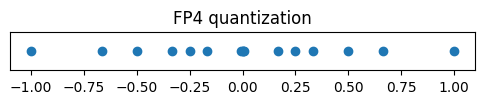

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, .5))
ax.scatter(x=sorted(fp4_state['weight.quant_map'].tolist()), y=[0]*16)
ax.set_yticks([])
ax.set_title('FP4 quantization')

In [67]:
nf4_model = nf4_model.to(0) # Quantization happens here
nf4_state = nf4_model.state_dict()

nf4_state['weight.quant_map'], nf4_state['weight'].shape

(tensor([-1.0000, -0.6962, -0.5251, -0.3949, -0.2844, -0.1848, -0.0911,  0.0000,
          0.0796,  0.1609,  0.2461,  0.3379,  0.4407,  0.5626,  0.7230,  1.0000],
        device='cuda:0'),
 torch.Size([50, 1]))

Text(0.5, 1.0, 'NF4 quantization')

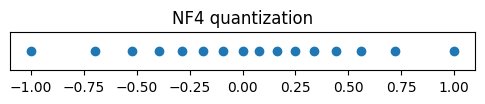

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, .5))
ax.scatter(x=sorted(nf4_state['weight.quant_map'].tolist()), y=[0]*16)
ax.set_yticks([])
ax.set_title('NF4 quantization')

### Coming Up in "Fine-Tuning LLMs"

As huge linear layers are being replaced by their quantized versions to reduce the model’s memory footprint, a
new issue arises. These quantized layers cannot be easily updated, thus rendering fine-tuning next to
impossible. Could a new kind of layer be the solution to this conundrum? Find out in the next thrilling chapter
of "Fine-Tuning LLMs."